In [1]:
# Imports
import time
import pandas as pd
import numpy as np
import scipy
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
# Plot settings for retina
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Filenames
f_name = 'single-proj_scenario.csv'
augmented_f_name = 'single-proj_scenario_with_text.csv'
out_f_name = 'pr_dataset.json'

In [3]:
# Create dataframe with PR data
def load_pr_data() -> pd.DataFrame:
    f_bots = 'bots.txt'
    with open(f_name) as f:
        raw_df = pd.read_csv(f_name)
    with open(f_bots) as f:
        bots = f.read().splitlines()
    return raw_df[~raw_df['Author'].isin(bots)]

In [4]:
raw_df = load_pr_data()

In [5]:
# Add empty "text" column
raw_df['Text'] = ''

In [6]:
# Hanle API tokens

class APIToken:
    def __init__(self):
        self.token_index = 0
        self.tokens = [
            'c8407e53938eea5e027377eb744efe67850f3e0a', # SA-2019
            '8657769a09149655d1942a975c074f6d9441da4a', # SA-2019
            '55866a3ccee6c1ee5e32727958687cd1ad29d55b'  # Pr_study_1
        ]
        
    def next(self):
        tok = self.tokens[self.token_index]
        self.token_index = (self.token_index + 1) % len(self.tokens)
        return tok

In [7]:
# Ask GitHub api for PR text

# Construct API url
def get_api_url(repo_url: str, pr_num: int) -> str:
    owner_repo = repo_url[len("https://github.com/"):]
    return f"https://api.github.com/repos/{owner_repo}/pulls/{pr_num}"

# Request pr and return PR title and body
def get_pr_text(full_url: str, tok: APIToken, retries: int) -> str:
    QUERY = { 'access_token': tok.next() }
    HEADERS = { 'Accept': "application/vnd.github.v3+json" }
    try:
        r = requests.get(url = full_url, params = QUERY, headers = HEADERS)
        if (r.status_code != 200):
            print(f"\tError in request: {r.text}")
            if ('Retry-After' in r.headers):
                print(f"\tRetrying after: {r.headers['Retry-After']}")
                time.sleep(r.headers['Retry-After'])
                return get_pr_text(full_url, tok, retries - 1)
            else:
                print(f"\tRate limit remaining: {r.headers['X-RateLimit-Remaining']}")
                return ''
        else:
            j = r.json()
            return j['title'] + '\n' + j['body']
    except ConnectionError:
        if (retries > 0):
            print(f"\tConnectionError in request for {repo_url}. Retrying ({retries} retries left).")
            time.sleep(10)
            return get_pr_text(full_url, tok, retries - 1)
        else:
            print(f"\tConnectionError in request for {repo_url}. Returning ''.")
            return ''
    except:
        print(f"\tUnknown error in request for {repo_url}. Returning ''.")
        return ''
    
def fetch_pr_texts(_df: pd.DataFrame) -> pd.DataFrame:
    # Request text for all PR in df, add retrieved text to df
    api_token = APIToken()
    for i in range(len(raw_df)):
        if (i > 4000):
            break
        row = raw_df.loc[i]
        repo_url = row['Repo']
        pr_num = row['PR_Number']
        URL = get_api_url(repo_url, pr_num)
        print(f"{i}: Requesting {URL}")
        text = get_pr_text(URL, api_token, retries = 5)
        raw_df.loc[i, 'Text'] = text
    raw_df.to_csv(augmented_f_name, index = False)
    return raw_df

In [8]:
def load_local_prs_with_text() -> pd.DataFrame:
    with open(augmented_f_name) as f:
        _df = pd.read_csv(f)
    return _df[~_df['Text'].isna()]

In [9]:
# Either load locally saved file, or re-load PR tests from GitHub

# df = fetch_pr_texts(raw_df)
df = load_local_prs_with_text()

In [10]:
def add_text_len(_df: pd.DataFrame) -> pd.DataFrame:
    return _df\
        .assign(TextLen=lambda d: d['Text'].str.len())

In [11]:
textlen_df = add_text_len(df)

In [12]:
textlen_df.head()

,Author,Repo,PR_Number,ClosingTime,GeneralCommentsReceived,SourceCodeCommentsReceived,AcceptancePercentage,Merged?,PastPR,PastCommits,...,AvgGeneralCommentsReceived,AvgSourceCodeCommentsReceived,AvgAcceptancePercentage,Senti4SDAvg-General,Senti4SDAvg-SourceCode,SentiSSEAvg-General,SentiSSEAvg-SourceCode,creationDate,Text,TextLen
0,AMecea,https://github.com/silverapp/silver,301,25.0,2.0,0.0,100.000000,True,0,1,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,2016-02-17T11:05:28Z,fix unicode exceptions.\nThis fix PressLabs/bi...,62
1,AMecea,https://github.com/presslabs/z3,8,827632.0,2.0,2.0,50.000000,False,1,4,...,NaN,NaN,NaN,0.0,0.0,0.0,-0.5,2016-08-10T16:17:50Z,fix reading from ~/.z3.cfg file for config and...,100
2,AMecea,https://github.com/silverapp/silver,358,1027.0,3.0,3.0,66.666664,True,2,4,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,2016-11-15T18:44:32Z,Test transactions\nfixes #344,29
3,AMecea,https://github.com/silverapp/silver,372,14575.0,1.0,9.0,50.000000,False,3,5,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2016-11-18T08:05:04Z,Transaction state (fixes #364)\nCR\n\nfixes #364,46
4,AMecea,https://github.com/silverapp/silver,373,17.0,1.0,0.0,60.000000,True,4,5,...,1.8,2.8,0.6,0.0,NaN,0.0,NaN,2016-11-18T08:52:21Z,Add drone publish image. And fix requirment de...,57


In [13]:
def textlen_distribution(_df: pd.DataFrame, title: str, fname: str = None):
    plt.rcParams["figure.figsize"] = [16,10]
    sns.boxplot(orient="h", data=_df[['TextLen']]).set_title(title)
    if fname:
        plt.savefig(f'figures/{fname}', bbox_inches='tight')
    plt.show()

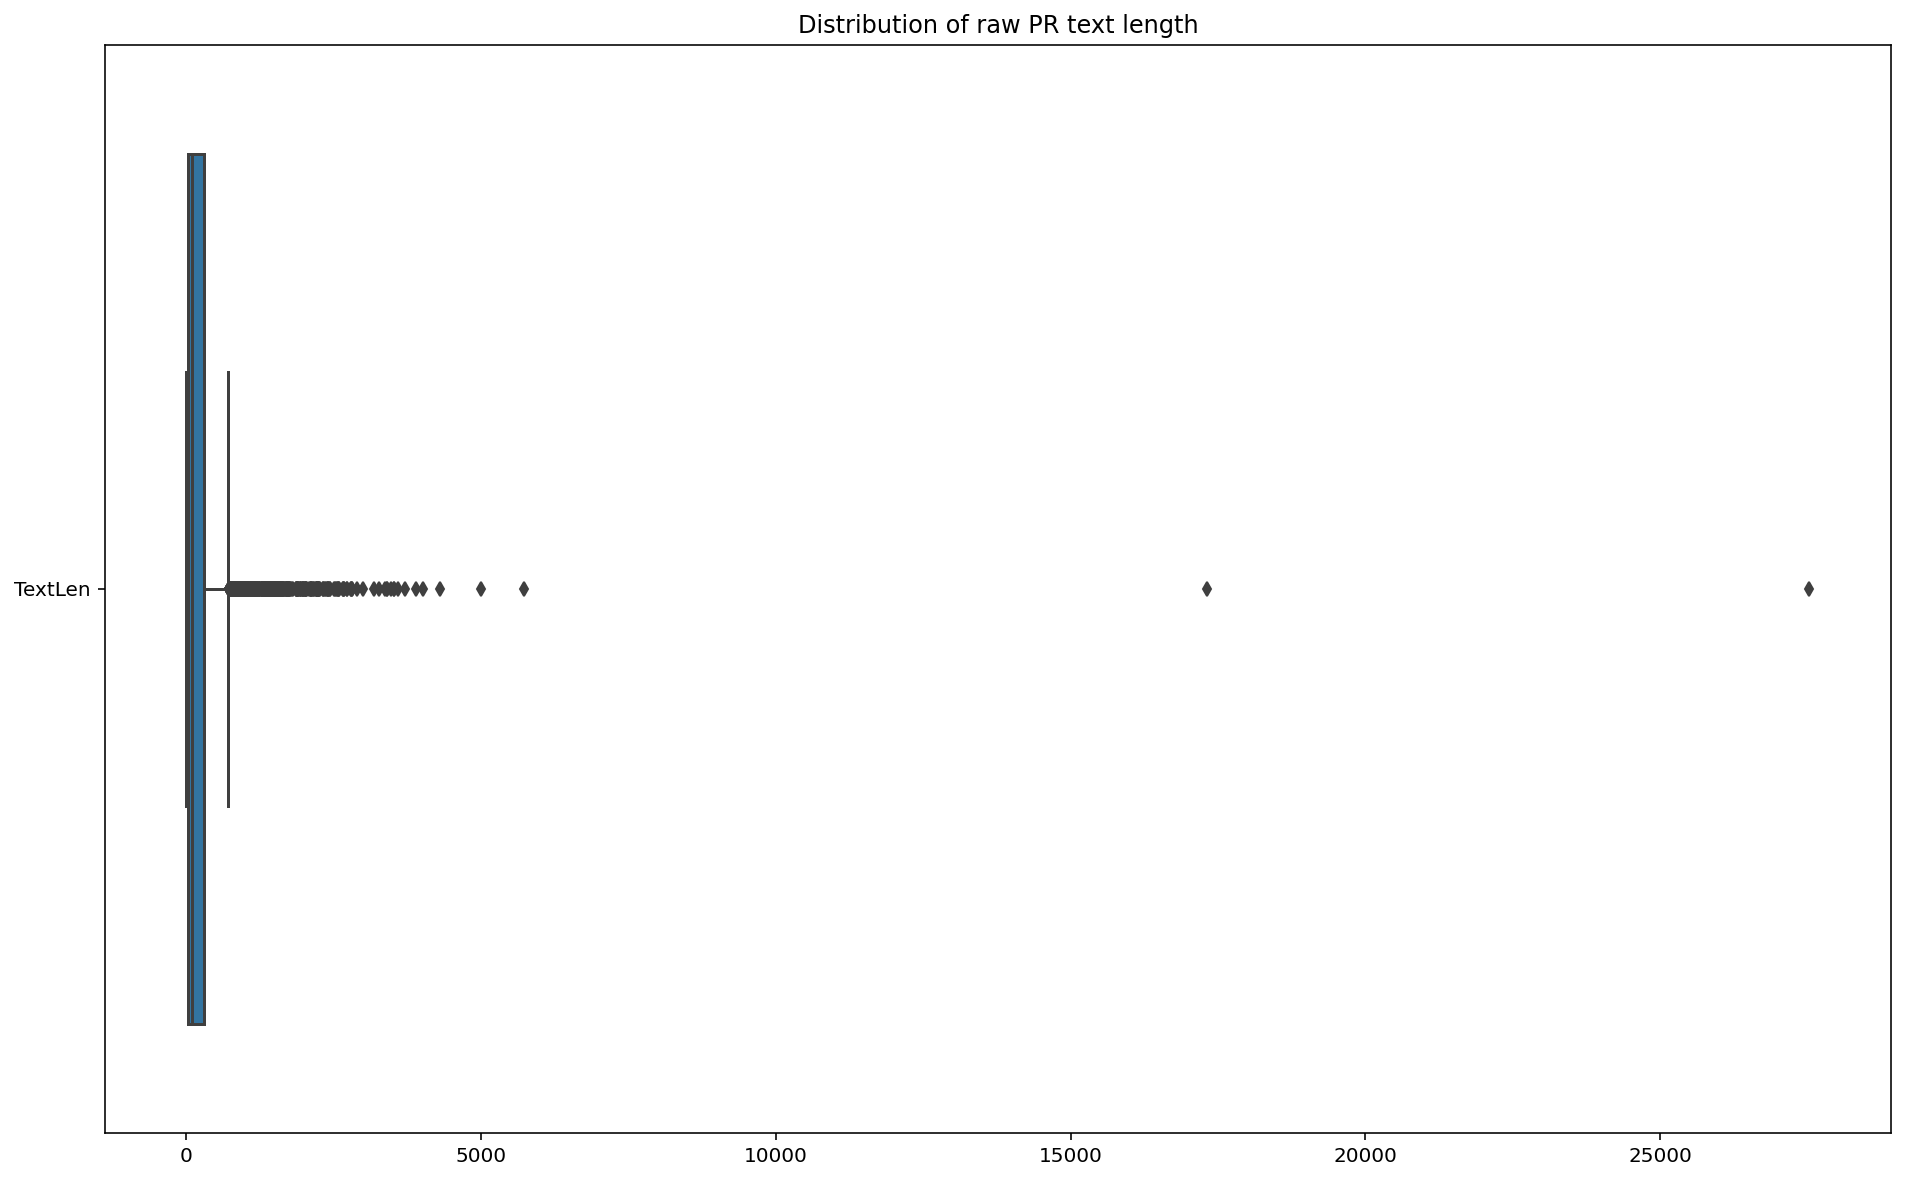

In [14]:
textlen_distribution(textlen_df, 'Distribution of raw PR text length')

In [15]:
def remove_outliers(_df: pd.DataFrame, use_z_score: bool = True) -> pd.DataFrame:
    if use_z_score:
        z_scores = scipy.stats.zscore(_df[['TextLen']])
        abs_z_scores = np.abs(z_scores)
        non_outlier = (abs_z_scores < 3).all(axis=1)
        return _df[non_outlier]
    else:
        Q1 = _df['TextLen'].quantile(0.25)
        Q3 = _df['TextLen'].quantile(0.75)
        IQR = Q3 - Q1
        outlier = (_df['TextLen'] < (Q1 - 1.5 * IQR)) | (_df['TextLen'] > (Q3 + 1.5 * IQR))
        return _df[~outlier]

In [16]:
def inspect_long_text(_df: pd.DataFrame, above: int = 2000):
    for i, t in _df[_df['TextLen'] > above].reset_index()['Text'].iteritems():
        print('_' * 100)
        print(t)
    
inspect_long_text(remove_outliers(textlen_df))

____________________________________________________________________________________________________
ERC721 safeTransfer new callback
Replaced ERC721TokenReceiver with new implementation, `onERC721Received(address, uint256, bytes) `-> `onERC721Received(address, address, uint256, bytes)`

```solidity
/// @dev Note: the ERC-165 identifier for this interface is 0x150b7a02.
interface ERC721TokenReceiver {
    /// @notice Handle the receipt of an NFT
    /// @dev The ERC721 smart contract calls this function on the recipient
    ///  after a `transfer`. This function MAY throw to revert and reject the
    ///  transfer. Return of other than the magic value MUST result in the
    ///  transaction being reverted.
    ///  Note: the contract address is always the message sender.
    /// @param _operator The address which called `safeTransferFrom` function
    /// @param _from The address which previously owned the token
    /// @param _tokenId The NFT identifier which is being transferred
    

In [17]:
def remove_short_and_dirty_text(_df: pd.DataFrame) -> pd.DataFrame:
    min_len = 50
    stack_trace = [': java.lang.']
    portuguese = ['Documentação', 'Motivação']
    japanese_chinese = ["分", "割", "し", "て", "少", "な", "素", "で", "じ", "マ", "く", "メ", "を", "酸", "わ", "ン", "構", "よ", "う", "英", "い", "の", "報", "が", "ク", "シ", "に", "コ", "れ", "た", "す", "る", "舰", "娘"]
    french = ["être", "numéro", "était", "ça", "première", "généré", "triés", "votre"]
    german = ["Bestätigungen", "öffnen", "berechtigung", "Entität", "anschauen", "weißt", "irgendwelche", "Vielleicht", "ungefähr", "standardmäßig", "geprüft", "wäre", "Änderungen", "folgendermaßen", "können", "Übersichtsseite", "überall", "funktioniert"]
    italian = ["migliorare", "visualizzazione"]
    all_dirty = [
        *stack_trace,
        *portuguese,
        *japanese_chinese,
        *french,
        *german,
        *italian
    ]
    is_text_dirty = _df['Text'].str.contains('|'.join(all_dirty))
    is_text_too_short = (_df['TextLen'] < min_len)
    return _df[~is_text_dirty & ~is_text_too_short].reset_index(drop=True)

In [18]:
clean_df = remove_short_and_dirty_text(remove_outliers(textlen_df, False))

In [19]:
inspect_long_text(clean_df, above=0)

____________________________________________________________________________________________________
fix unicode exceptions.
This fix PressLabs/billing/issues/187

____________________________________________________________________________________________________
fix reading from ~/.z3.cfg file for config and pep8.
Make z3 to search for `~/.z3.cfg` config file.

____________________________________________________________________________________________________
Add drone publish image. And fix requirment dependences.

____________________________________________________________________________________________________
Add zone tests.
Here are just some tests for zone api. More will come...
____________________________________________________________________________________________________
Fix stripping of domain root in test + reason for second test failing

____________________________________________________________________________________________________
Check if a cname exists when


____________________________________________________________________________________________________
Dougsch fix examples
Fixed a number of bad links and typos in the .NET Dev Guide.

By submitting this pull request, I confirm that you can use, modify, copy, and redistribute this contribution, under the terms of your choice.

____________________________________________________________________________________________________
AWS.config.mediaconvert is a property, not a function
Some MediaConvert examples were treating AWS.config.mediaconvert as a function.

Changed usage to a property.


By submitting this pull request, I confirm that my contribution is made under the terms of the Apache 2.0 license.

____________________________________________________________________________________________________
Fixed comment chars after moving snippet tags
Comment chars for snippet tags were incorrect.

// ... -> <!-- ... -->


By submitting this pull request, I confirm that my contribution is m

bots: Add libvirt-dbus to rhel-x image
 * [x] image-refresh rhel-x
____________________________________________________________________________________________________
machines: reducers: ui: Fix state mutations
See why immutability is needed for redux managed state here:
https://redux.js.org/faq/immutabledata#why-is-immutability-required-by-redux
____________________________________________________________________________________________________
machines: adjust tests to not require nested kvm
* Don't fail if kvm is not available
* Don't fail when eror is "CPU is incompatible with host CPU"

There is open issue for the later: https://github.com/cockpit-project/cockpit/issues/8385
____________________________________________________________________________________________________
machines: fix race condition when updating VM UI info
We should update UI only if both dumpxml and dominfo calls succeeded.
If the first succeeded and the second failed, we 'll get a UI with
visible VM missing

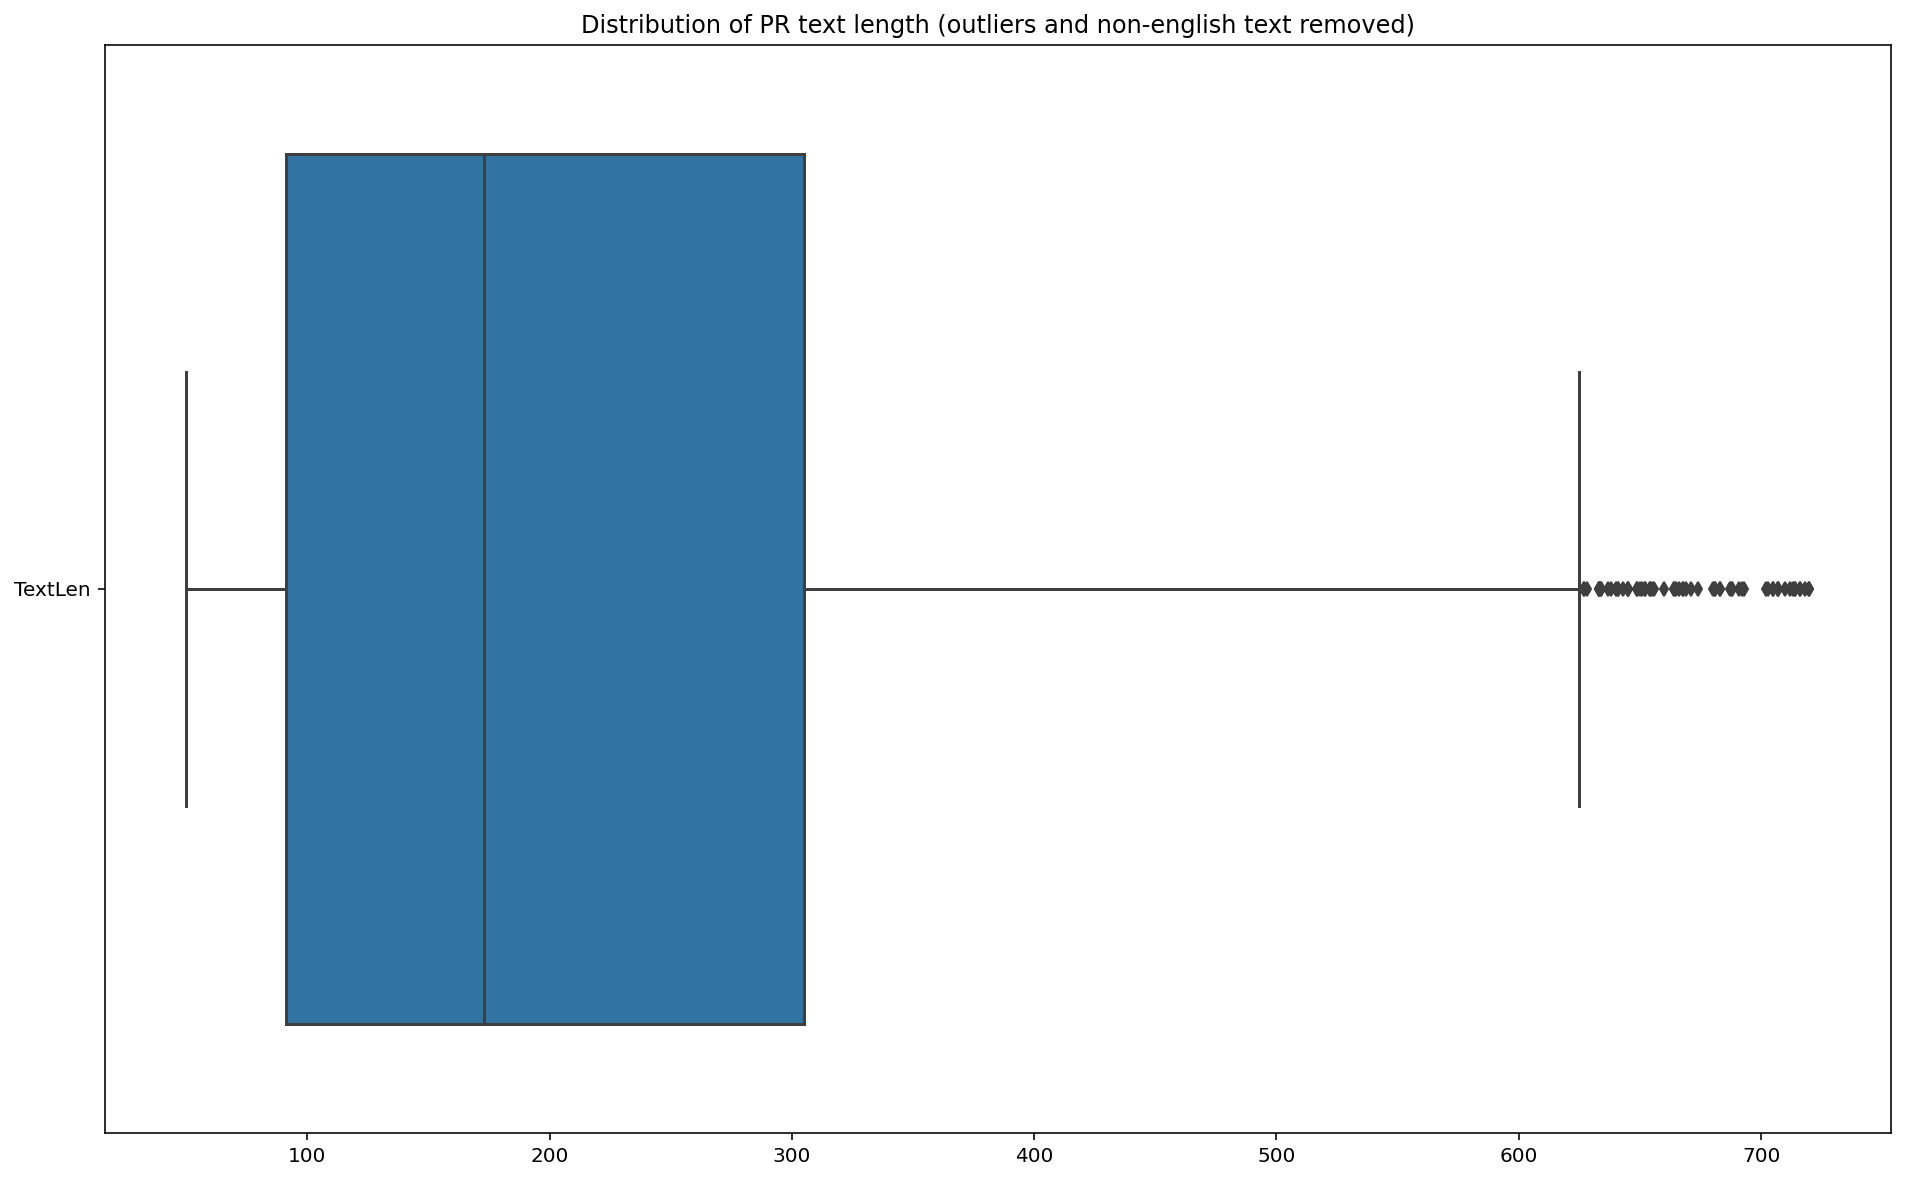

In [20]:
textlen_distribution(
    clean_df,
    'Distribution of PR text length (outliers and non-english text removed)',
    fname = 'pr-description-length-distribution'
)

In [24]:
print(clean_df[['ClosingTime', 'TextLen']].describe().to_latex())

\begin{tabular}{lrr}
\toprule
{} &   ClosingTime &      TextLen \\
\midrule
count &  2.157000e+03 &  2157.000000 \\
mean  &  1.388939e+04 &   219.667130 \\
std   &  6.761610e+04 &   162.602263 \\
min   &  0.000000e+00 &    50.000000 \\
25\%   &  1.240000e+02 &    91.000000 \\
50\%   &  1.296000e+03 &   173.000000 \\
75\%   &  5.983000e+03 &   305.000000 \\
max   &  1.552042e+06 &   720.000000 \\
\bottomrule
\end{tabular}



In [22]:
# Write as JSON file
def write_json(_df: pd.DataFrame):
    _df.rename(columns={
        'Merged?' : 'IsMerged',
        'Senti4SDAvg-General' : 'Senti4SDAvgGeneral',
        'Senti4SDAvg-SourceCode' : 'Senti4SDAvgSourceCode',
        'SentiSSEAvg-General' : 'SentiSSEAvgGeneral',
        'SentiSSEAvg-SourceCode' : 'SentiSSEAvgSourceCode',
    }).to_json(out_f_name, orient='records')
    
write_json(clean_df)